In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib

## 1. 데이터 전처리 (로그 변환 + 스케일링)

In [2]:
# 1. Preprocessing Pipeline
def preprocess_data(train_path, test_path):
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Log transform revenue
    train_df['log_revenue'] = np.log1p(train_df['revenue'])
    test_df['log_revenue'] = np.log1p(test_df['revenue'])

    # Update the genre feature columns (assuming they are from 'War' to 'Horror')
    genre_features = train_df.loc[:, 'War':'Horror'].columns.tolist()
    features = [
        'budget', 'popularity', 'runtime', 'vote_average', 'vote_count',
        'release_year', 'collection_id', 'director_score', 'actor_score', 'production_score'] + genre_features

    # Apply Scaler to numerical features
    # scaler = RobustScaler()
    # numerical_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'director_score', 'actor_score', 'production_score']
    # train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
    # test_df[numerical_features] = scaler.transform(test_df[numerical_features])

    # Save scaler for future use
    # joblib.dump(scaler, 'scaler.pkl')

    # Return preprocessed data and feature list (LSTM 아닐 경우 주석 해제)
    return train_df, test_df, features

## 2. 모델 훈련

### 2-1. 랜덤 포레스트

In [3]:
# 2-1. Model Training Pipeline (Random Forest Regressor)
def train_model_Random_Forest(X_train, y_train, model_params=None):
    # Set default model parameters if none are provided
    if model_params is None:
        model_params = {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}

    # Initialize and train the model
    model = RandomForestRegressor(**model_params)
    model.fit(X_train, y_train)

    # Save the trained model
    # joblib.dump(model, 'model/series_movie_revenue_predictor_18.pkl')

    return model


#### 2-1-1. 랜덤 포레스트 : 하이퍼파라미터 튜닝

In [4]:
def hyperparameter_tuning_Random_Forest(X_train, y_train):
    # Set the parameters for grid search
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Initialize the model
    model = RandomForestRegressor(random_state=42)

    # Perform grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    # Return the best model
    return grid_search.best_estimator_

### 2-2. LGBM

In [5]:
# Step 2-2. Model Training Pipeline (LightGBM Regressor)
def train_model_lightgbm(X_train, y_train, model_params=None):
    # Set default model parameters if none are provided
    if model_params is None:
        model_params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 100
        }

    # Initialize LightGBM model
    model = lgb.LGBMRegressor(**model_params)

    # Train the model
    model.fit(X_train, y_train)

    # Save the trained model
    # joblib.dump(model, 'series_movie_revenue_predictor_lightgbm.pkl')

    return model

#### 2-2-1. LGBM : 하이퍼파라미터 튜닝

In [6]:
# Step 2-2-1: LGBM Hyperparameter Tuning
def hyperparameter_tuning_lightgbm(X_train, y_train):
    param_grid = {
        'num_leaves': [31, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300, 400],
    }
    model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mae')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

### 2-3. XGboost

In [7]:
def train_model_xgboost(X_train, y_train, model_params=None):
    # Set default model parameters if none are provided
    if model_params is None:
        model_params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'max_depth': 6,
            'n_estimators': 100,
            'random_state': 42
        }

    # Initialize XGBoost model
    model = xgb.XGBRegressor(**model_params)

    # Train the model
    model.fit(X_train, y_train)

    # Save the trained model
    # joblib.dump(model, 'series_movie_revenue_predictor_xgboost.pkl')

    return model

#### 2-3-1. XGboost : 하이퍼파라미터 튜닝

In [8]:
def hyperparameter_tuning_xgboost(X_train, y_train):
    param_grid = {
        'random_state': [42],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 9],
        'n_estimators': [100, 200, 300, 400]
    }
    model = xgb.XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

## 3. 모델 평가 및 시각화

### 3-1. LSTM 아닌 모델

In [9]:
def evaluate_model(model, X_test, y_test_log):
    # Predict on the test set (log scale)
    y_test_pred_log = model.predict(X_test)

    # Convert log predictions and actual values back to original scale
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_actual = np.expm1(y_test_log)

    # Calculate evaluation metrics
    test_r2 = r2_score(y_test_actual, y_test_pred)
    test_mae = mean_absolute_error(y_test_actual, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    test_mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)

    # Print evaluation metrics
    print(f"Test R2 Score: {test_r2}")
    print(f"Test Mean Absolute Error (MAE): {test_mae}")
    print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
    print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape}")

    # Plot actual vs predicted values for visual comparison
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_actual, y_test_pred, alpha=0.5)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()],
             color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')
    plt.title('Actual vs Predicted Revenue for Test Set (Log Transformation Applied)')
    plt.show()

In [10]:
train_path = 'data/maindata_ver2.0_train.csv'
test_path = 'data/maindata_ver2.0_test.csv'

In [11]:
# LSTM 아닌 경우
train_df, test_df, features = preprocess_data(train_path, test_path)

In [12]:
# Feature와 Target 분리 (LSTM 아닌 경우))
X_train = train_df[features]
y_train = train_df['log_revenue']
X_test = test_df[features]
y_test = test_df['log_revenue']

In [13]:
# Train the model(LSTM 아닌 경우)
model = train_model_lightgbm(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 811, number of used features: 23
[LightGBM] [Info] Start training from score 18.137836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Test R2 Score: 0.8431842511764233
Test Mean Absolute Error (MAE): 49835274.356220916
Test Root Mean Squared Error (RMSE): 91928224.44167826
Test Mean Absolute Percentage Error (MAPE): 8.000723188821448


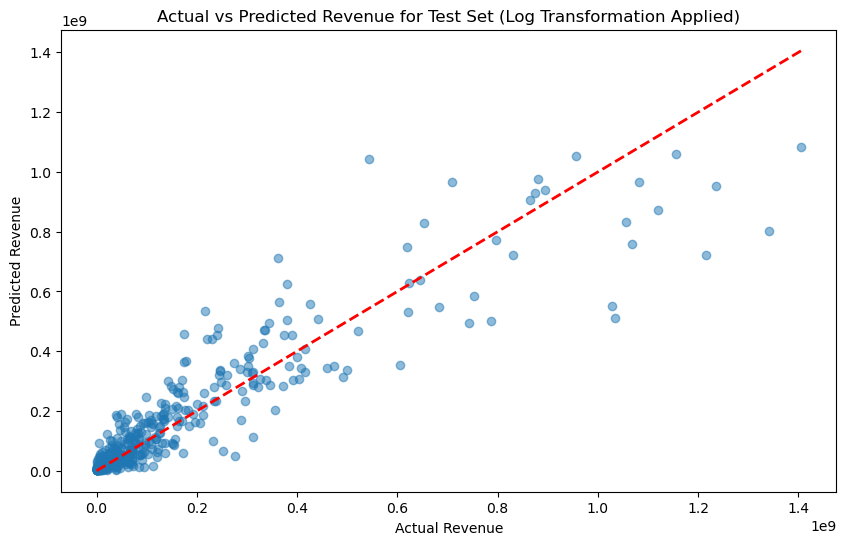

In [14]:
# Evaluate the model(LSTM 아닌 경우)
evaluate_model(model, X_test, y_test)

# Evaluate the model(LSTM인 경우)

In [15]:
# Optional : Perform Hyperparameter Tuning
# tuned_model = hyperparameter_tuning_lightgbm(X_train, y_train)
# Evaluate the tuned model
# evaluate_model(tuned_model, X_test, y_test)

- 우우.. 결과가 아쉽다..

In [16]:
average_revenue_train = train_df['revenue'].mean()
average_revenue_test = test_df['revenue'].mean()

print(f"Average Revenue in Train Set: {average_revenue_train}")
print(f"Average Revenue in Test Set: {average_revenue_test}")

Average Revenue in Train Set: 194217759.48335388
Average Revenue in Test Set: 147374012.87201735
